In [2]:
# Authors - Karanjit Singh, Rishabh Manish Sahlot, Tejas Patel
from myutils import hourToLabelEncoder
import pandas as pd
import math
from datetime import datetime
from pymongo import MongoClient


client = MongoClient()
# Estabilishing a connection with an already existing database named taxi_data
db = client['taxi_data']
# Selecting the collection/table yellowtaxi_data
coll = db['yellowtaxi_data']
coll.drop()

# Initializing the Folder paths
raw_data_path = 'Raw_Data/'
processed_data_path = 'Processed_Data/'
links_data_path = 'Data_Links/'
# Reading the df_nypd data
df_nypd = pd.read_csv(raw_data_path+'nypd_data.csv')
# Finding the year and month of crime for the nypd data
df_nypd['year of crime'] = list(map(lambda x: str(x.split('/')[2]), df_nypd['ARREST_DATE'].values))
df_nypd['month of crime'] = list(map(lambda x: str(x.split('/')[0]), df_nypd['ARREST_DATE'].values))
# Aggregating the number of arrests for each precinct
crime_counts = df_nypd.groupby('ARREST_PRECINCT').agg(['count'])['ARREST_KEY']
# Saving the new df_nypd file in the porcessed data as well as removing it from the memory
# Since it will not be used the preprocessing henceforth.
#df_nypd.to_csv(processed_data_path +'nypd_data.csv')
del df_nypd
# Reading the precinct lookup table
df_taxi_with_precint = pd.read_csv(links_data_path+'taxi_with_precint.csv')
# Correcting the pipe separated values to array elements in the 'Corresponding_Taxi_Zones' column
df_taxi_with_precint['Corresponding_Taxi_Zones'] = list( map(lambda x: list(map(int,x.split('|'))),df_taxi_with_precint['Corresponding_Taxi_Zones'].values))
# merging the counts of arrest for each precint and the Corresponding Taxi Zones for the Precint
crime_counts = crime_counts.merge(df_taxi_with_precint, left_on='ARREST_PRECINCT', right_on='NYPD Precinct')
# Saving (in the processed Folder) and deleting(from the program cache) the precinct lookup
# since it's use has been over.
#df_taxi_with_precint.to_csv(processed_data_path +'taxi_with_precint.csv')
del df_taxi_with_precint
# Assigning crime rate labels for hardcoded(using visualization) values of arrest counts
crime_counts['CrimeRate'] = 1
crime_counts['CrimeRate'][crime_counts['count'] < 45000] = 'Low Crime'
crime_counts['CrimeRate'][(crime_counts['count'] >= 45000) & (crime_counts['count'] < 90000)] = 'Medium Crime'
crime_counts['CrimeRate'][crime_counts['count'] >= 90000] = 'High Crime'
# Flattening / unwinding the crime counts to get each taxi zone
crime_counts = crime_counts.explode('Corresponding_Taxi_Zones')

## Moving on to University Data
# Reading the university data
df_uni = pd.read_csv(raw_data_path+'cuny_locations.csv')
# The above data is clean and should be saved and deleted from memory since it has no later significance
df_uni.to_csv(processed_data_path +'cuny_location.csv')
del df_uni
# Reading Univeristy Lookup Table as well as saving it to it's corresponding Location
df_uni_lookup = pd.read_csv(links_data_path+'taxi_with_cuny.csv')
#df_uni_lookup.to_csv(processed_data_path+'taxi_with_cuny.csv')

#Moving on to the taxi Data
# Reading the taxi zone lookup data
df_taxi_zone_lookup = pd.read_csv(links_data_path+'taxi_zone_lookup.csv')
# Since it contains all the location ID's in the taxi data, we can do the merging
# operation to this one- this saves a lot of time and program memory
df_taxi_zone_lookup = pd.merge(df_taxi_zone_lookup, crime_counts[['Corresponding_Taxi_Zones','CrimeRate']], left_on='LocationID', right_on='Corresponding_Taxi_Zones', how='left')
df_taxi_zone_lookup = pd.merge(df_taxi_zone_lookup, df_uni_lookup, left_on='LocationID', right_on='Location ID', how='left')
# Freeing space of the non-essential merged items
del crime_counts
del df_uni_lookup
#Now using the College ID data obtained from we add the HasSchool feature
df_taxi_zone_lookup['HasSchool'] = 'false'
df_taxi_zone_lookup['HasSchool'][df_taxi_zone_lookup['College ID'].notna()] = 'true'
# We then drop of waste columns
del df_taxi_zone_lookup['Location ID']
del df_taxi_zone_lookup['Corresponding_Taxi_Zones']
del df_taxi_zone_lookup['College ID']
del df_taxi_zone_lookup['Zone']
del df_taxi_zone_lookup['service_zone']

# Finally we read the taxi trip data
df_taxi = pd.read_csv(raw_data_path+'yellowtaxi_data.csv')
# First and foremost we clean the data
# 1. Remove All values with trip distance less than or equal to 0
df_taxi = df_taxi.drop(df_taxi[df_taxi['trip_distance'] <= 0].index)
# 2. Remove All values with total amount less than 0
df_taxi = df_taxi.drop(df_taxi[df_taxi['total_amount'] <= 0].index)
# 3.
df_taxi = df_taxi.drop(df_taxi[df_taxi['extra'] < 0].index)
#4.
df_taxi = df_taxi.drop(df_taxi[df_taxi['PULocationID'] > 263].index)
#5.
df_taxi = df_taxi.drop(df_taxi[df_taxi['DOLocationID'] > 263].index)
# Fix the date time columns
df_taxi['tpep_pickup_datetime'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), df_taxi['tpep_pickup_datetime'].values))
df_taxi['tpep_dropoff_datetime'] =list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), df_taxi['tpep_dropoff_datetime'].values))
# Calculate trip duration in hours
df_taxi['Trip duration'] = list(map(lambda x: x.item()/(3600*(10**9)), (df_taxi['tpep_dropoff_datetime']-df_taxi['tpep_pickup_datetime']).values))
# Incidently I found that trip duration becomes negative in some cases i.e. pickup happening after drop off, we dont try to analyze these values and simply eliminate them
df_taxi = df_taxi.drop(df_taxi[df_taxi['Trip duration'] <= 0].index)

# Calculating average speed during the trip
df_taxi['Speed'] = df_taxi['trip_distance']/df_taxi['Trip duration']
# Thresholding for speed to predict traffic such lower speed of vehicles implies higher traffic
df_taxi['Traffic'] = 0
df_taxi['Traffic'][df_taxi['Speed']<=10] = 'High Traffic'
df_taxi['Traffic'][(df_taxi['Speed']>10) & (df_taxi['Speed']<=25)] = 'Medium Traffic'
df_taxi['Traffic'][df_taxi['Speed']>25] = 'Low Traffic'
# Calculating Hour the the dat HoD for the dropoff (DOHoD) & pickup values (PUHoD)
df_taxi['DOHoD'] = df_taxi['tpep_dropoff_datetime'].astype('datetime64[ns]').dt.hour
df_taxi['PUHoD'] = df_taxi['tpep_pickup_datetime'].astype('datetime64[ns]').dt.hour
# Calculating the respective Time Codes using these values
df_taxi['DOTimeCode'] = list(map(lambda x: hourToLabelEncoder(x), df_taxi['DOHoD'].values))
df_taxi['PUTimeCode'] = list(map(lambda x: hourToLabelEncoder(x), df_taxi['PUHoD'].values))
# Finally Merging All the Data From the combined taxi zone lookup data
df_taxi = pd.merge(df_taxi, df_taxi_zone_lookup, left_on='PULocationID', right_on='LocationID',how='left')
#Getting columns of the comibined values
exterior_columns = df_taxi_zone_lookup.columns
# Changing names in dt_taxi to indicate they are for pickup location
for cols in exterior_columns:
    df_taxi.rename(columns={cols: 'PU'+cols}, inplace=True)
# Repeating the same with DO locations
df_taxi = pd.merge(df_taxi, df_taxi_zone_lookup, left_on='DOLocationID', right_on='LocationID',how='left')
#Storing & Deleting the combined values
df_taxi_zone_lookup.to_csv(processed_data_path+'taxi_zone_lookup.csv')
del df_taxi_zone_lookup
# Changing names in dt_taxi to indicate they are for pickup location
for cols in exterior_columns:
    df_taxi.rename(columns={cols: 'DO'+cols}, inplace=True)

# Finally storing the taxi data at it's require position
#df_taxi.to_csv(processed_data_path+'yellowtaxi_data.csv')


c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\risha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\rish

In [3]:
df_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,DOTimeCode,PUTimeCode,PULocationID,PUBorough,PUCrimeRate,PUHasSchool,DOLocationID,DOBorough,DOCrimeRate,DOHasSchool
0,1,2019-04-01 00:04:09,2019-04-01 00:06:35,1,0.5,1,N,239,239,1,...,0-6,0-6,239,Manhattan,Low Crime,false,239,Manhattan,Low Crime,false
1,1,2019-04-01 00:22:45,2019-04-01 00:25:43,1,0.7,1,N,230,100,2,...,0-6,0-6,230,Manhattan,Medium Crime,false,100,Manhattan,High Crime,true
2,1,2019-04-01 00:39:48,2019-04-01 01:19:39,1,10.9,1,N,68,127,1,...,0-6,0-6,68,Manhattan,Low Crime,false,127,Manhattan,NaN,false
3,1,2019-04-01 00:35:32,2019-04-01 00:37:11,1,0.2,1,N,68,68,2,...,0-6,0-6,68,Manhattan,Low Crime,false,68,Manhattan,Low Crime,false
4,1,2019-04-01 00:44:05,2019-04-01 00:57:58,1,4.8,1,N,50,42,1,...,0-6,0-6,50,Manhattan,Medium Crime,false,42,Manhattan,Medium Crime,false


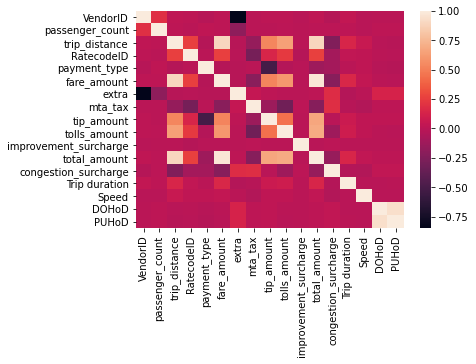

In [4]:
import seaborn as sn
sn.heatmap(df_taxi.corr(nominal_columns=catcols))
nominal_columns=catcols

In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
client = MongoClient()
result = client['taxi_data']['yellowtaxi_data'].aggregate([
    {'$project':{"_id": 1, 'tip_amount': 1, 'total_amount': 1, 'trip_distance': 1, 'PUBorough': 1, 'PUTimecode': 1, 'DOHasSchool': 1, 'time_taken': {'$divide': [{'$subtract':['$tpep_dropoff_datetime','$tpep_pickup_datetime']},60000]}}}
])
df = pd.DataFrame(list(result))



#Creating groups of different time of the day
df['time_group'] = df['time_taken'].apply(lambda y: 1 if (y > 360 and y <= 600) else (
    2 if (y > 600 and y <= 660) else (3 if (y > 660 and y <= 720) else (4 if (y > 720 and y <= 840) else (
        5 if (y > 840 and y <= 960) else (6 if (y > 960 and y <= 1080) else (
            7 if (y > 1080 and y <= 1560) else (8 if (y > 1560 and y <= 1680) else 9))))))))

#Giving weights to the borough for clustering
df['borough_weight'] = df['PUBorough'].apply(lambda r: 6 if r == 'Bronx' else (8 if r == 'Brooklyn' else (
    2 if r == 'EWR' else (9 if r == 'Manhattan' else (3 if r == 'Staten Island' else (7 if r == 'Queens' else 1))))))


#Creating numeric column for presence of school
df['hasSchool'] = df['DOHasSchool'].apply(lambda d: 0 if d is False else 1)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

#Displaying the data
print('** Yellow Cab Data **')
print(df.head())

#Selcting the required features for clustering
X = df[['tip_amount', 'total_amount', 'trip_distance', 'borough_weight', 'hour_weight', 'hasSchool']]

#Converting pandas to numpy
X_ = X.to_numpy()

#Splitting data into training and testing data (70% training and 30% testing)
X_train, X_test = train_test_split(X_, test_size=0.3)

#Executing k-means clustering algorithm
kmeans = KMeans(algorithm='auto', n_clusters=3, copy_x=True, init='k-means++', max_iter=600,
                n_init=10, n_jobs=1, precompute_distances='auto', tol=0.0001)
kmeans.fit(X_train)

#Calculating  and displaying centers of the clusters
centres = kmeans.cluster_centers_
print("** Centers of Training Clusters **")
print(centres)
print()


#Displaying the list of assigned cluster to each row
cluster = kmeans.labels_
print('** Training clusters assigned **')
print(cluster)
print()


X_train, X_test = train_test_split(X_, test_size=0.1)


#Predicting and displaying test clusters
print('** Testing data clusters assigned **')
test = kmeans.predict(X_test)
print(test)
print()

#Plotting the test clusters
plt.scatter(X_test[:, 0], X_test[:, 1], c=test, s=60, cmap='viridis')
plt.show()

#Calculating and displaying silhouette score
sil = silhouette_score(X_test, test)
print("Silhouette score for the testing data = ", sil)